### **Análisis del conjunto de datos**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# 1. Cargar el archivo CSV
pd.set_option('display.width', 1000)
dataframe = pd.read_csv('anemia.csv')
print("Datos iniciales:")
print(dataframe.head())  # Muestra los primeros registros para una vista rápida de cómo están estructurados los datos.

Datos iniciales:
   Gender  Hemoglobin   MCH  MCHC   MCV  Result
0       1        14.9  22.7  29.1  83.7       0
1       0        15.9  25.4  28.3  72.0       0
2       0         9.0  21.5  29.6  71.2       1
3       0        14.9  16.0  31.4  87.5       0
4       1        14.7  22.0  28.2  99.5       0


In [17]:
# 2. Exploración inicial del conjunto de datos
print("\nInformación general del conjunto de datos:")
print(dataframe.info())  # Muestra información general del conjunto de datos.

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
# Eliminar las columnas 'gender' y 'result' del DataFrame antes de describirlo
dataframe_sin_columnas = dataframe.drop(columns=['Gender', 'Result'])
print(dataframe_sin_columnas.describe())  # Muestra estadísticas descriptivas de las columnas numéricas.

# Contar el número de hombres y mujeres
print("\nCantidad de hombres y mujeres:")
gender_counts = dataframe['Gender'].value_counts()
print(gender_counts)

# Valores únicos por columna para identificar posibles problemas
print("\nValores únicos por columna:")
print(dataframe.nunique())  # Muestra la cantidad de valores únicos por columna.

# 3. Revisión y manejo de valores nulos
print("\nValores nulos por columna:")
print(dataframe.isnull().sum())  # Muestra la cantidad de valores nulos por columna.


Información general del conjunto de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      1421 non-null   int64  
 1   Hemoglobin  1421 non-null   float64
 2   MCH         1421 non-null   float64
 3   MCHC        1421 non-null   float64
 4   MCV         1421 non-null   float64
 5   Result      1421 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 66.7 KB
None

Estadísticas descriptivas:
        Hemoglobin          MCH         MCHC          MCV
count  1421.000000  1421.000000  1421.000000  1421.000000
mean     13.412738    22.905630    30.251232    85.523786
std       1.974546     3.969375     1.400898     9.636701
min       6.600000    16.000000    27.800000    69.400000
25%      11.700000    19.400000    29.000000    77.300000
50%      13.200000    22.700000    30.400000    85.300000
75%      15.000000    26.200000 


Visualización de distribuciones individuales de las características:


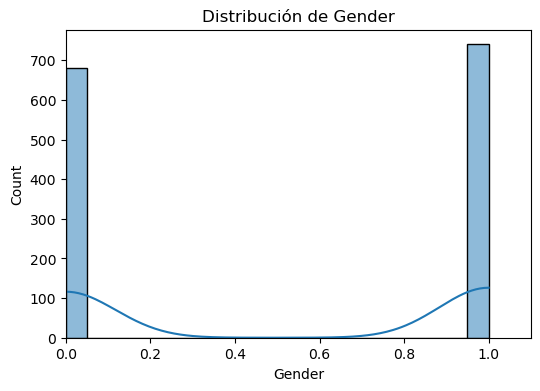

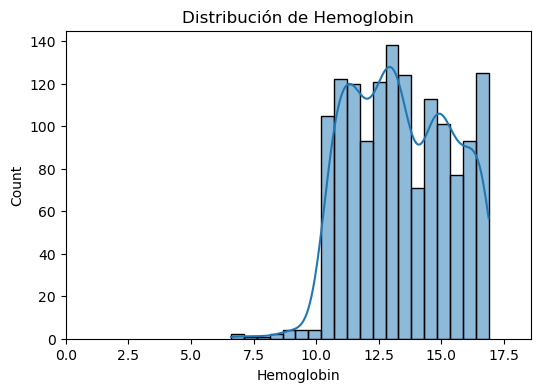

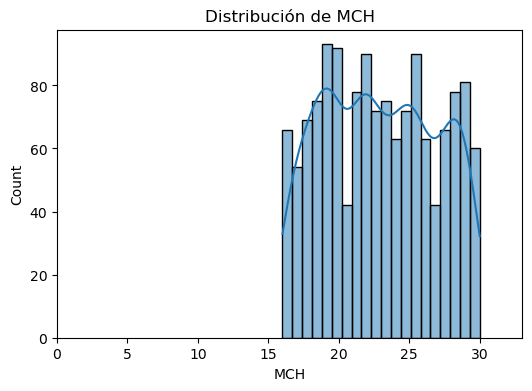

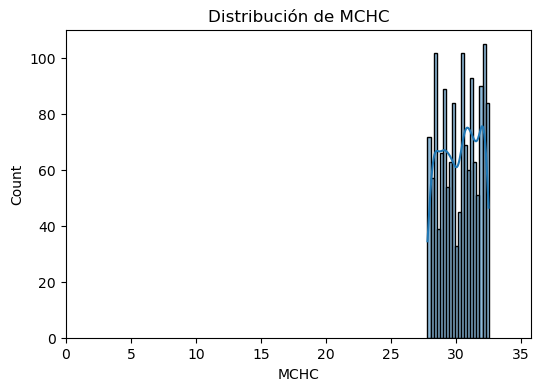

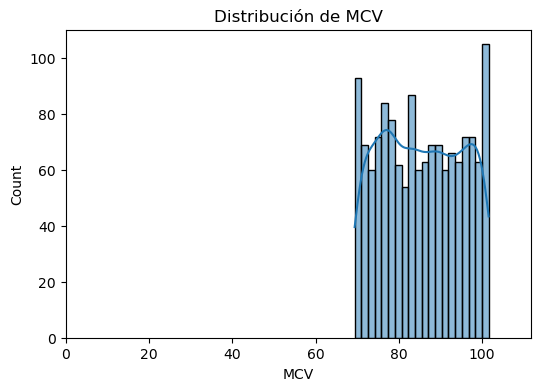

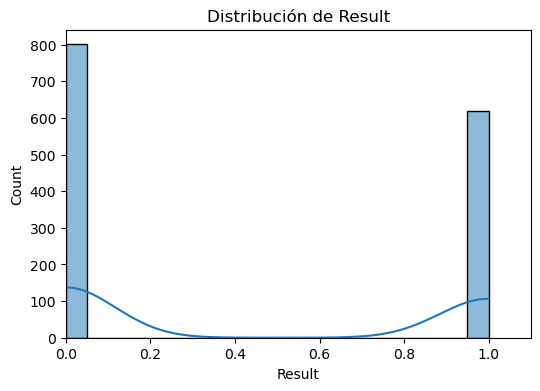

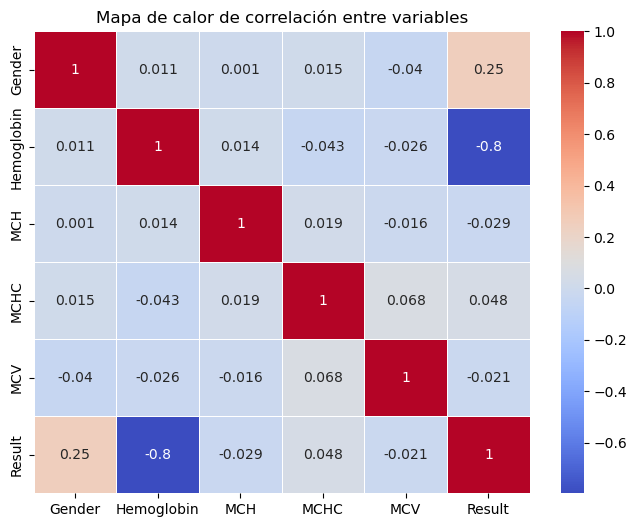

In [18]:
# 4. Exploración detallada de características
print("\nVisualización de distribuciones individuales de las características:")
for column in dataframe.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(dataframe[column].dropna(), kde=True, bins=20)  # Un histograma con KDE para visualizar la forma de la distribución.
    plt.title(f'Distribución de {column}')
    plt.xlim(0, dataframe[column].max() * 1.1)  # Ajustar límites del eje X para ver mejor la distribución completa.
    plt.show()

# Mapa de calor de correlación entre variables
# Visualizamos la correlación entre las variables para detectar relaciones importantes entre las características.
plt.figure(figsize=(8, 6))
sns.heatmap(dataframe.corr(), annot=True, cmap='coolwarm', linewidths=0.5)  # Se destaca con anotaciones el valor de la correlación.
plt.title('Mapa de calor de correlación entre variables')
plt.show()


Distribución de clases (0: No tiene anemia, 1: Tiene anemia):


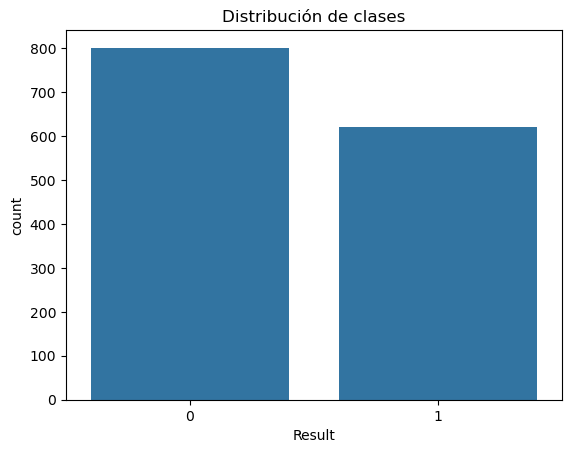


Distribución de clases en porcentaje:
Result
0    56.368754
1    43.631246
Name: proportion, dtype: float64


In [19]:
# 5. Evaluación del balance de clases
print("\nDistribución de clases (0: No tiene anemia, 1: Tiene anemia):")
sns.countplot(x='Result', data=dataframe)
plt.title('Distribución de clases')
plt.show()

# Mostrar el porcentaje de cada clase.
print("\nDistribución de clases en porcentaje:")
print(dataframe['Result'].value_counts(normalize=True) * 100)

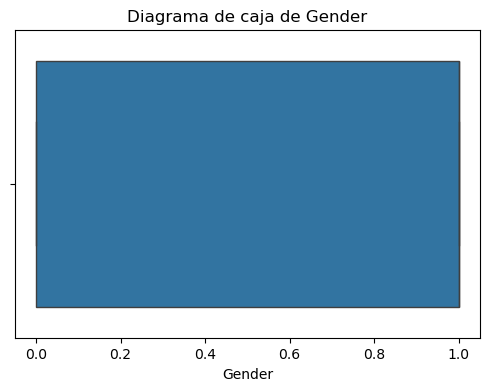

Outliers detectados en Gender: 0 (0.00% del total)


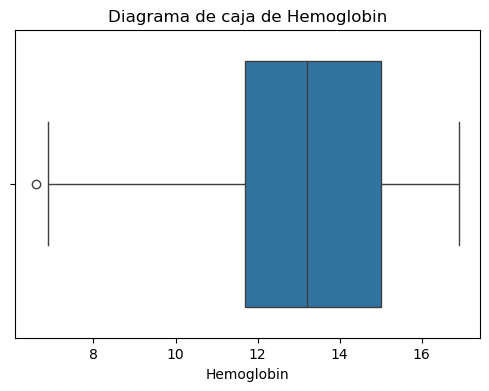

Outliers detectados en Hemoglobin: 1 (0.07% del total)


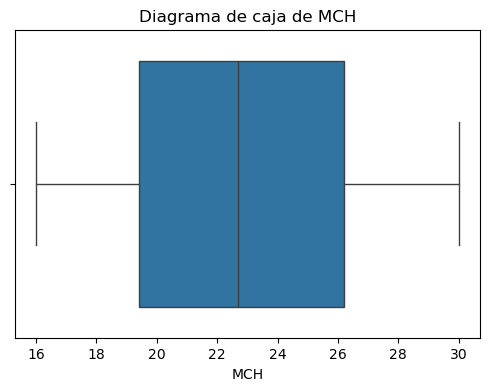

Outliers detectados en MCH: 0 (0.00% del total)


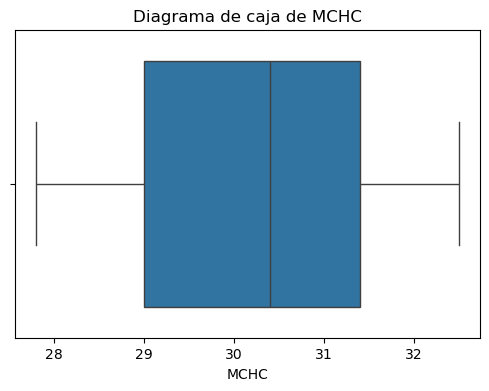

Outliers detectados en MCHC: 0 (0.00% del total)


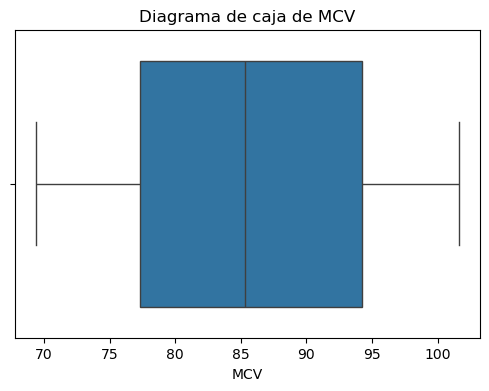

Outliers detectados en MCV: 0 (0.00% del total)


In [6]:
# 6. Detección de outliers usando diagramas de caja
# Seleccionamos las columnas relevantes para detectar outliers.
columnas_relevantes = ['Gender', 'Hemoglobin', 'MCH', 'MCHC', 'MCV']
for column in columnas_relevantes:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=dataframe[column])  # Un boxplot para visualizar outliers basados en el IQR.
    plt.title(f'Diagrama de caja de {column}')
    plt.show()

    # Detección de outliers utilizando el rango intercuartílico (IQR)
    # Calculamos los valores atípicos con el IQR (Interquartile Range) para cada columna relevante.
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = dataframe[(dataframe[column] < (Q1 - 1.5 * IQR)) | (dataframe[column] > (Q3 + 1.5 * IQR))]
    porcentaje_outliers = (len(outliers) / len(dataframe)) * 100
    print(f"Outliers detectados en {column}: {len(outliers)} ({porcentaje_outliers:.2f}% del total)")


Exploración de relaciones entre variables:


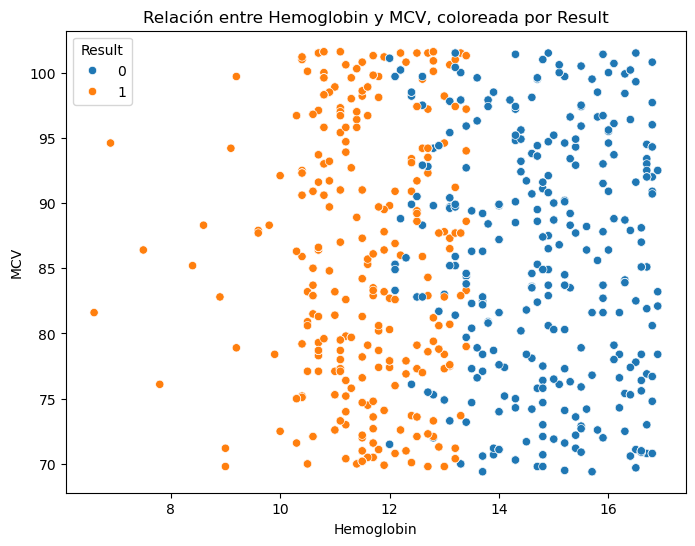

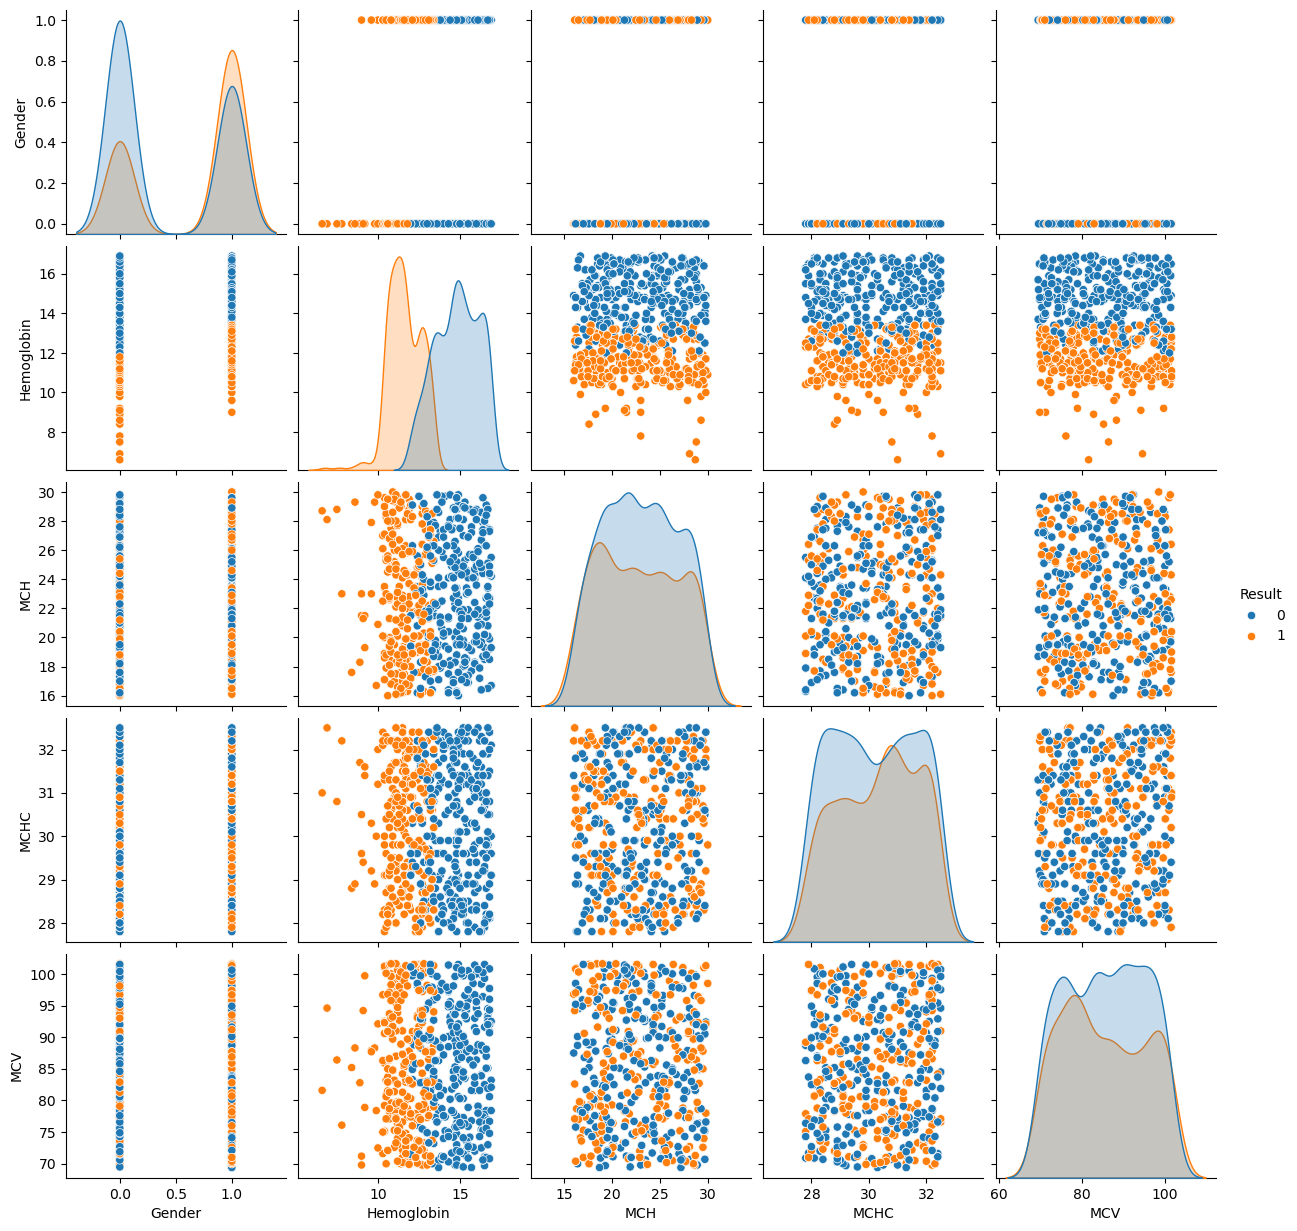

In [7]:
# 7. Exploración de relaciones entre variables
print("\nExploración de relaciones entre variables:")
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Hemoglobin', y='MCV', hue='Result', data=dataframe)  # Un scatter plot para explorar la relación entre dos variables clave.
plt.title('Relación entre Hemoglobin y MCV, coloreada por Result')
plt.show()

# Pares de variables para explorar relaciones adicionales
sns.pairplot(dataframe, hue='Result', vars=['Gender', 'Hemoglobin', 'MCH', 'MCHC', 'MCV'])  # Utilizamos pairplots para analizar múltiples relaciones.
plt.show()

# Justificación adicional: las relaciones entre vaiables como 'Hemoglobin' y 'MCV' pueden ser útiles para predecir tipos de anemia.

### **Modelo y evaluación**

In [8]:
# 8. Separación de datos para entrenamiento, validación y prueba
X = dataframe.drop('Result', axis=1)  # Características
Y = dataframe['Result']  # Etiquetas

# División de datos en entrenamiento, validación y prueba
# Se utiliza una proporción de 70% para entrenamiento, 15% para validación y 15% para prueba.
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.30, random_state=42, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.50, random_state=42, stratify=Y_temp)

# Normalización de características para manejar outliers y mejorar la convergencia del modelo.
# Justificación: Aplicamos MinMaxScaler para normalizar las características en un rango de 0 a 1, reduciendo el impacto de los outliers.
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

""" # Prueba de Shapiro-Wilk para saber si los datos siguen una distribución normal
# Si es una distribución normal, se utilizará StandardScaler
# Si no es una distribución normal, por la naturaleza de los datos y la futura implementación de KNN se utilizará MinMaxScaler

from scipy.stats import shapiro
columna = 'Result'
stat, p = shapiro(dataframe[columna])
print(f'Estadístico de Shapiro-Wilk: {stat}, p-valor: {p}')
if p > 0.05:
    print('Los datos parecen seguir una distribución normal (no se rechaza H0)')
else:
    print('Los datos no siguen una distribución normal (se rechaza H0)') """

# Verificación las formas de los conjuntos
# Esto asegura que la partición haya sido correcta y que las dimensiones de los conjuntos sean las esperadas.
print(f"\nForma del conjunto de entrenamiento: {X_train.shape}, {Y_train.shape}")
print(f"Forma del conjunto de validación: {X_val.shape}, {Y_val.shape}")
print(f"Forma del conjunto de prueba: {X_test.shape}, {Y_test.shape}")

# Verificación del balance de clases en los conjuntos de entrenamiento, validación y prueba
# Esta función ayuda a verificar que la proporción de clases (0: no tiene anemia, 1: tiene anemia) se mantenga después de la partición.
def check_class_balance(y, label):
    print(f"\nDistribución de clases en el conjunto de {label}:")
    print(y.value_counts(normalize=True) * 100)

# Verificamos el balance de clases en los conjuntos de entrenamiento, validación y prueba.
check_class_balance(Y_train, "entrenamiento")
check_class_balance(Y_val, "validación")
check_class_balance(Y_test, "prueba")


Forma del conjunto de entrenamiento: (994, 5), (994,)
Forma del conjunto de validación: (213, 5), (213,)
Forma del conjunto de prueba: (214, 5), (214,)

Distribución de clases en el conjunto de entrenamiento:
Result
0    56.338028
1    43.661972
Name: proportion, dtype: float64

Distribución de clases en el conjunto de validación:
Result
0    56.338028
1    43.661972
Name: proportion, dtype: float64

Distribución de clases en el conjunto de prueba:
Result
0    56.542056
1    43.457944
Name: proportion, dtype: float64



Distribución de clases después de aplicar SMOTE en los datos de entrenamiento:
Result
1    50.0
0    50.0
Name: proportion, dtype: float64

Distribuciones antes de SMOTE (normalizadas):


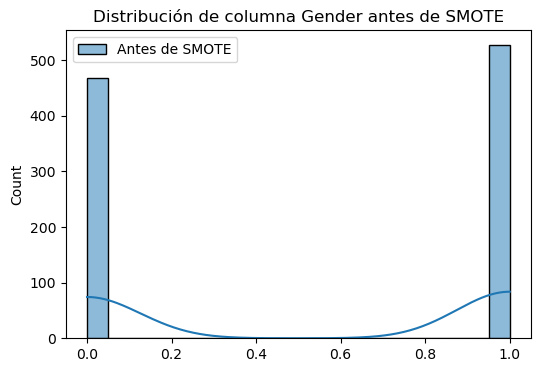

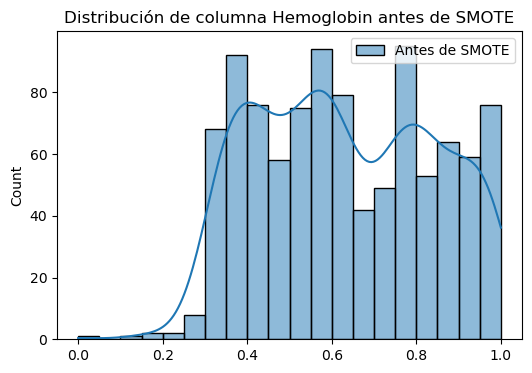

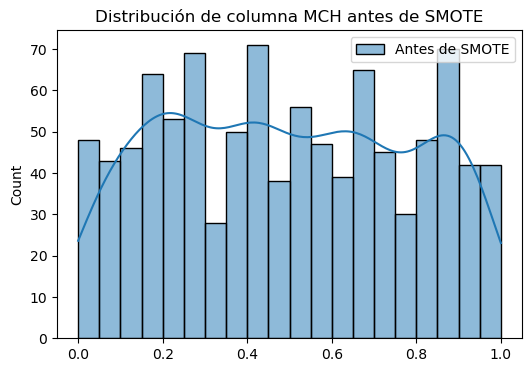

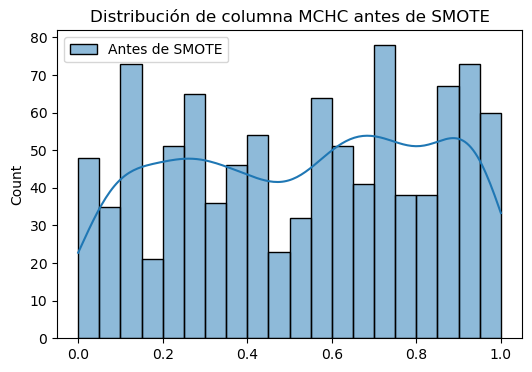

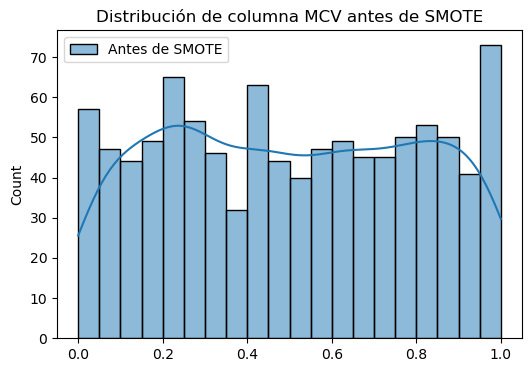


Distribuciones después de SMOTE (normalizadas):


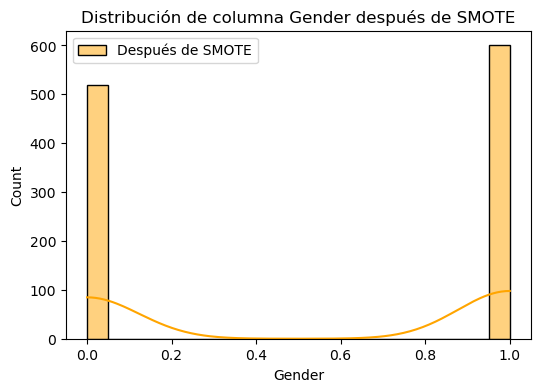

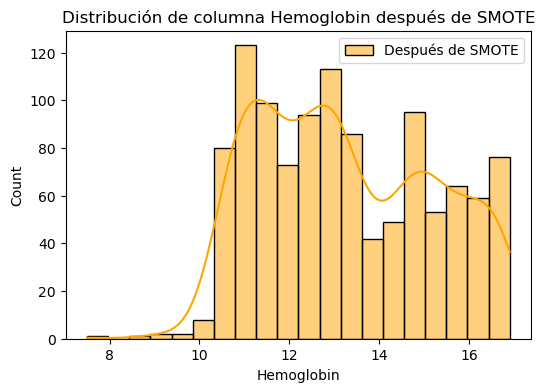

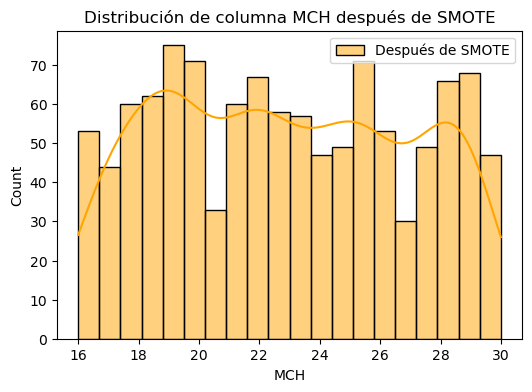

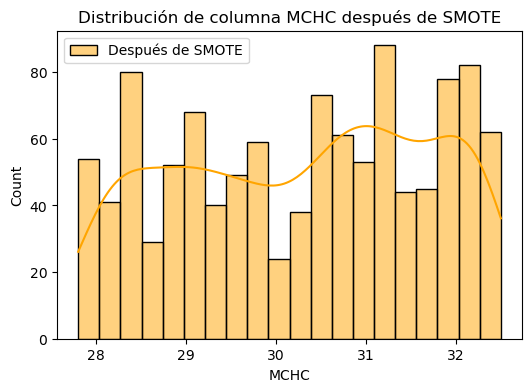

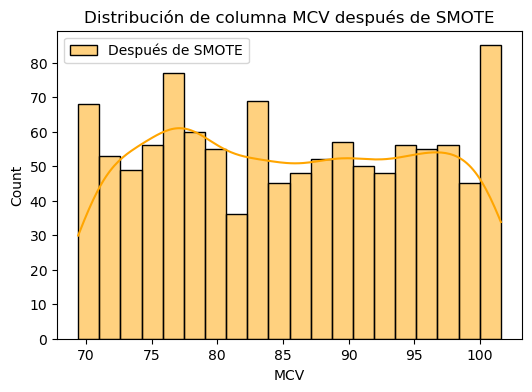

In [9]:
# 9. Sobremuestreo usando SMOTE
# El dataset tiene un desbalance de clases significativo (aproximadamente 56% no anémicos, 44% anémicos).
# Esto puede afectar el desempeño de los modelos, especialmente en la capacidad de detectar correctamente los casos positivos (recall).
# Por esta razón, utilizamos SMOTE para generar ejemplos sintéticos de la clase minoritaria. También aplicamos ajuste de pesos en la regresión 
# logística para mejorar la sensibilidad a la clase minoritaria.

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, Y_train)

# Verificación del nuevo balance de clases después de aplicar SMOTE
# Nos aseguramos de que las clases estén balanceadas al 50/50 en el conjunto de entrenamiento después de SMOTE.
print("\nDistribución de clases después de aplicar SMOTE en los datos de entrenamiento:")
print(pd.Series(y_resampled).value_counts(normalize=True) * 100)

# Visualización de las distribuciones antes y después de SMOTE
# Justificación: Verificamos las distribuciones de las columnas antes y después de SMOTE para asegurarnos de que no se alteraron significativamente.

print("\nDistribuciones antes de SMOTE (normalizadas):")
for column in range(X_train_scaled.shape[1]):
    plt.figure(figsize=(6, 4))
    sns.histplot(X_train_scaled[:, column], kde=True, bins=20, label='Antes de SMOTE')
    plt.title(f'Distribución de columna {X.columns[column]} antes de SMOTE')
    plt.legend()
    plt.show()

print("\nDistribuciones después de SMOTE (normalizadas):")
for column in range(X_resampled.shape[1]):
    plt.figure(figsize=(6, 4))
    sns.histplot(X_resampled.iloc[:, column], kde=True, bins=20, label='Después de SMOTE', color='orange')
    plt.title(f'Distribución de columna {X.columns[column]} después de SMOTE')
    plt.legend()
    plt.show()


Entrenando el modelo de Regresión Logística...

Resultados del modelo de Regresión Logística (Validación):
Accuracy: 0.9765
Precision: 0.9490
Recall: 1.0000
F1-Score: 0.9738
AUC-ROC: 0.9998


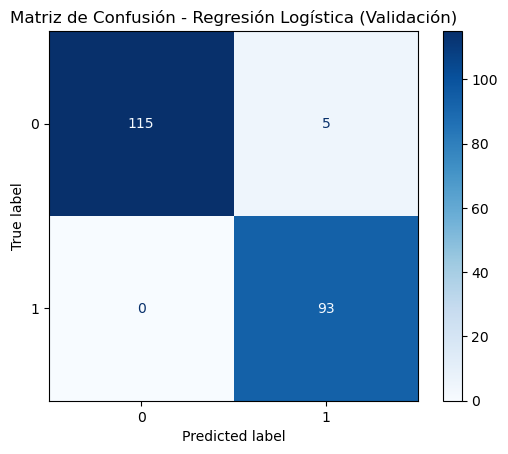


Resultados del modelo de Regresión Logística (Prueba):
Accuracy: 0.9626
Precision: 0.9208
Recall: 1.0000
F1-Score: 0.9588
AUC-ROC: 0.9997


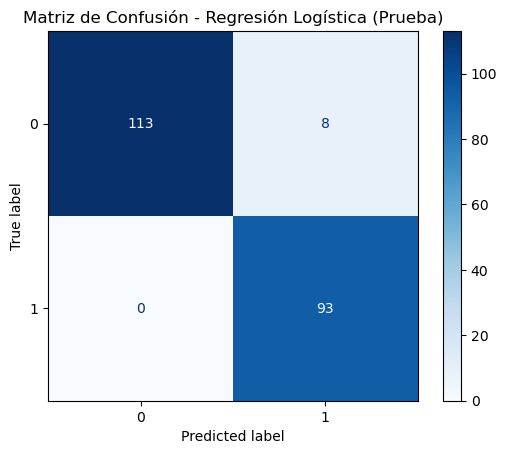

In [10]:
# 10.1 Entrenamiento de Modelo de Regresión Logística
# Aplicamos class_weight='balanced' para ajustar los pesos de las clases, mejorando el rendimiento en la clase minoritaria.
print("\nEntrenando el modelo de Regresión Logística...")
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_resampled, y_resampled)

# Verificación del modelo con el conjunto de validación
# Justificación: Validamos el modelo con el conjunto de validación para obtener métricas como accuracy, precision, recall, F1-score y AUC-ROC.
Y_val_pred_logreg = log_reg.predict(X_val)
Y_val_prob_logreg = log_reg.predict_proba(X_val)[:, 1]

# Evaluación del modelo de Regresión Logística en validación
print("\nResultados del modelo de Regresión Logística (Validación):")
print(f"Accuracy: {accuracy_score(Y_val, Y_val_pred_logreg):.4f}")
print(f"Precision: {precision_score(Y_val, Y_val_pred_logreg):.4f}")
print(f"Recall: {recall_score(Y_val, Y_val_pred_logreg):.4f}")

# Calculamos F1-Score para balancear precision y recall
f1_val_logreg = f1_score(Y_val, Y_val_pred_logreg)
print(f"F1-Score: {f1_val_logreg:.4f}")
# AUC-ROC para medir la capacidad del modelo para distinguir entre clases
auc_roc_val_logreg = roc_auc_score(Y_val, Y_val_prob_logreg)
print(f"AUC-ROC: {auc_roc_val_logreg:.4f}")

# Mostramos la matriz de confusión para la validación
cm_logreg = confusion_matrix(Y_val, Y_val_pred_logreg)
ConfusionMatrixDisplay(cm_logreg).plot(cmap='Blues')
plt.title("Matriz de Confusión - Regresión Logística (Validación)")
plt.show()

# Evaluación en el conjunto de prueba
# Justificación: Evaluamos el rendimiento final del modelo en el conjunto de prueba, que no ha sido utilizado en el entrenamiento o validación.
Y_test_pred_logreg = log_reg.predict(X_test)
Y_test_prob_logreg = log_reg.predict_proba(X_test)[:, 1]

print("\nResultados del modelo de Regresión Logística (Prueba):")
print(f"Accuracy: {accuracy_score(Y_test, Y_test_pred_logreg):.4f}")
print(f"Precision: {precision_score(Y_test, Y_test_pred_logreg):.4f}")
print(f"Recall: {recall_score(Y_test, Y_test_pred_logreg):.4f}")
# Calculamos F1-Score y AUC-ROC para el conjunto de prueba
f1_test_logreg = f1_score(Y_test, Y_test_pred_logreg)
print(f"F1-Score: {f1_test_logreg:.4f}")
auc_roc_test_logreg = roc_auc_score(Y_test, Y_test_prob_logreg)
print(f"AUC-ROC: {auc_roc_test_logreg:.4f}")

# Mostramos la matriz de confusión para el conjunto de prueba
cm_test_logreg = confusion_matrix(Y_test, Y_test_pred_logreg)
ConfusionMatrixDisplay(cm_test_logreg).plot(cmap='Blues')
plt.title("Matriz de Confusión - Regresión Logística (Prueba)")
plt.show()


Entrenando el modelo de K-Nearest Neighbors (KNN)...

Resultados del modelo de KNN (Validación):
Accuracy: 0.8498
Precision: 0.8081
Recall: 0.8602
F1-Score: 0.8333
AUC-ROC: 0.9544


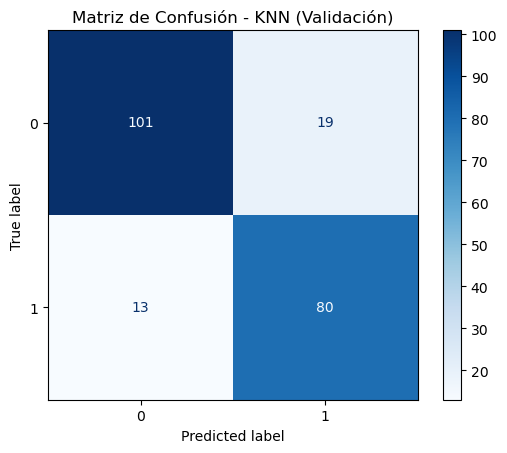


Resultados del modelo de KNN (Prueba):
Accuracy: 0.8925
Precision: 0.8571
Recall: 0.9032
F1-Score: 0.8796
AUC-ROC: 0.9747


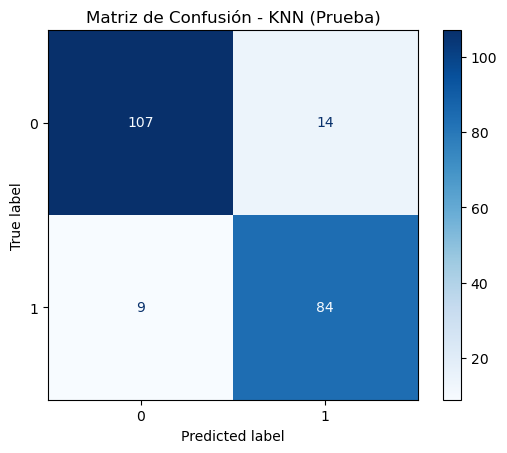

In [11]:
# 10.2 Entrenamiento de Modelo K-Nearest Neighbors (KNN)
# Justificación: Utilizamos KNN como segundo modelo de clasificación, beneficiándonos de los datos balanceados por SMOTE.
print("\nEntrenando el modelo de K-Nearest Neighbors (KNN)...")
knn = KNeighborsClassifier()
knn.fit(X_resampled, y_resampled)

# Verificación del modelo con el conjunto de validación
Y_val_pred_knn = knn.predict(X_val)
Y_val_prob_knn = knn.predict_proba(X_val)[:, 1]

# Evaluación del modelo KNN en Validación
print("\nResultados del modelo de KNN (Validación):")
print(f"Accuracy: {accuracy_score(Y_val, Y_val_pred_knn):.4f}")
print(f"Precision: {precision_score(Y_val, Y_val_pred_knn):.4f}")
print(f"Recall: {recall_score(Y_val, Y_val_pred_knn):.4f}")

# Calculamos F1-Score para KNN en validación
f1_val_knn = f1_score(Y_val, Y_val_pred_knn)
print(f"F1-Score: {f1_val_knn:.4f}")

# Calculamos AUC-ROC para KNN en validación
auc_roc_val_knn = roc_auc_score(Y_val, Y_val_prob_knn)
print(f"AUC-ROC: {auc_roc_val_knn:.4f}")

# Mostramos la matriz de confusión para la validación
cm_knn = confusion_matrix(Y_val, Y_val_pred_knn)
ConfusionMatrixDisplay(cm_knn).plot(cmap='Blues')
plt.title("Matriz de Confusión - KNN (Validación)")
plt.show()

# Evaluación en el conjunto de prueba
# Justificación: Evaluamos el rendimiento de KNN en el conjunto de prueba para compararlo con la regresión logística.
Y_test_pred_knn = knn.predict(X_test)
Y_test_prob_knn = knn.predict_proba(X_test)[:, 1]

print("\nResultados del modelo de KNN (Prueba):")
print(f"Accuracy: {accuracy_score(Y_test, Y_test_pred_knn):.4f}")
print(f"Precision: {precision_score(Y_test, Y_test_pred_knn):.4f}")
print(f"Recall: {recall_score(Y_test, Y_test_pred_knn):.4f}")

# Calculamos F1-Score y AUC-ROC para KNN en el conjunto de prueba
f1_test_knn = f1_score(Y_test, Y_test_pred_knn)
print(f"F1-Score: {f1_test_knn:.4f}")
auc_roc_test_knn = roc_auc_score(Y_test, Y_test_prob_knn)
print(f"AUC-ROC: {auc_roc_test_knn:.4f}")

# Mostramos la matriz de confusión para el conjunto de prueba
cm_test_knn = confusion_matrix(Y_test, Y_test_pred_knn)
ConfusionMatrixDisplay(cm_test_knn).plot(cmap='Blues')
plt.title("Matriz de Confusión - KNN (Prueba)")
plt.show()


Optimizando hiperparámetros de KNN...
Mejores parámetros para KNN: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

Resultados del modelo optimizado de KNN:
Accuracy: 0.9812
Precision: 0.9785
Recall: 0.9785


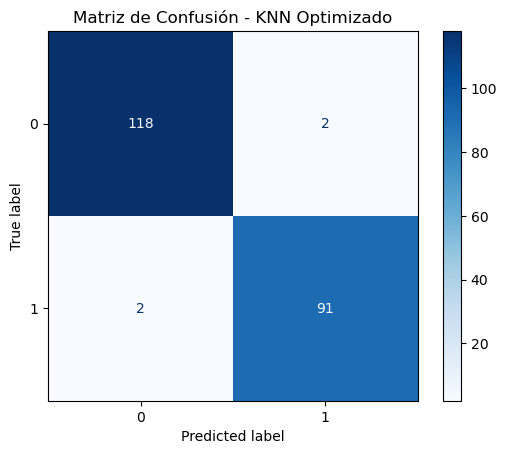

In [12]:
# 11. Optimización de hiperparámetros para KNN
print("\nOptimizando hiperparámetros de KNN...")

# Definir los hiperparámetros a buscar
# Buscamos optimizar el número de vecinos 'k', los pesos, y la métrica de distancia utilizada por el modelo KNN.
param_grid = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}

# Aplicar GridSearchCV para encontrar los mejores parámetros
# Usamos GridSearchCV para explorar todas las combinaciones posibles de los hiperparámetros y seleccionamos la mejor según la métrica de accuracy.
grid_knn = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Entrenar el modelo KNN con GridSearch
# Entrenamos el modelo KNN con las distintas combinaciones de hiperparámetros para identificar la configuración óptima.
grid_knn.fit(X_train, Y_train)

# Mostrar los mejores parámetros encontrados
print(f"Mejores parámetros para KNN: {grid_knn.best_params_}")

# Evaluación del modelo optimizado de KNN con el conjunto de validación
# Aplicamos el mejor modelo al conjunto de validación y evaluamos su rendimiento.
Y_val_pred_best_knn = grid_knn.predict(X_val)

# Evaluación del modelo KNN optimizado
print("\nResultados del modelo optimizado de KNN:")
print(f"Accuracy: {accuracy_score(Y_val, Y_val_pred_best_knn):.4f}")
print(f"Precision: {precision_score(Y_val, Y_val_pred_best_knn):.4f}")
print(f"Recall: {recall_score(Y_val, Y_val_pred_best_knn):.4f}")

# Mostrar matriz de confusión para KNN optimizado
# Visualizamos los resultados de la versión optimizada de KNN con la matriz de confusión.
cm_best_knn = confusion_matrix(Y_val, Y_val_pred_best_knn)
ConfusionMatrixDisplay(cm_best_knn).plot(cmap='Blues')
plt.title("Matriz de Confusión - KNN Optimizado")
plt.show()


Evaluación final con el conjunto de prueba...

Resultados finales de Regresión Logística en el conjunto de prueba:
Accuracy: 0.9626
Precision: 0.9208
Recall: 1.0000


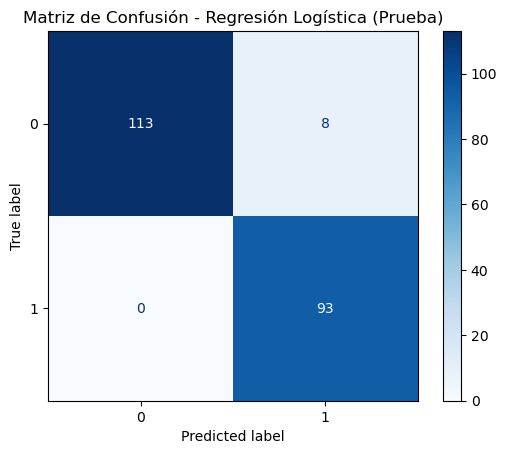


Resultados finales de KNN optimizado en el conjunto de prueba:
Accuracy: 0.9579
Precision: 0.9884
Recall: 0.9140


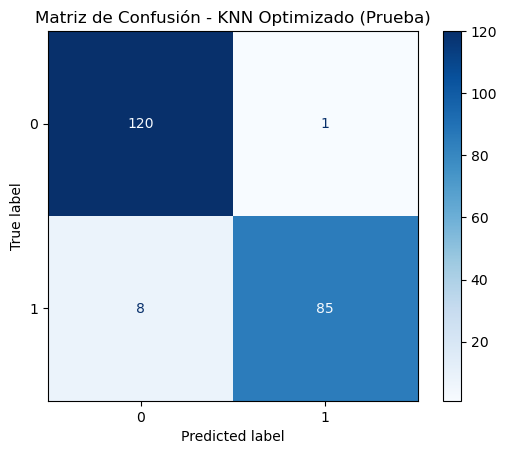

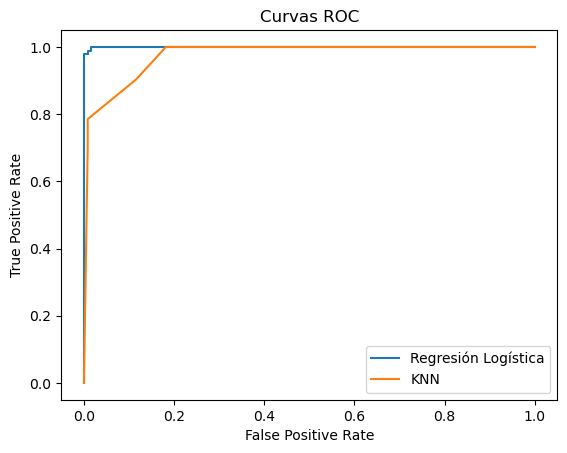

In [13]:
# 12. Evaluación final con el conjunto de prueba
print("\nEvaluación final con el conjunto de prueba...")

# Evaluar el modelo de Regresión Logística en el conjunto de prueba
# La evaluación final se realiza en el conjunto de prueba, que no se ha utilizado en ninguna parte del entrenamiento o validación.
y_test_pred_logreg = log_reg.predict(X_test)
print("\nResultados finales de Regresión Logística en el conjunto de prueba:")
print(f"Accuracy: {accuracy_score(Y_test, Y_test_pred_logreg):.4f}")
print(f"Precision: {precision_score(Y_test, Y_test_pred_logreg):.4f}")
print(f"Recall: {recall_score(Y_test, y_test_pred_logreg):.4f}")

# Mostrar matriz de confusión para Regresión Logística en el conjunto de prueba
cm_test_logreg = confusion_matrix(Y_test, Y_test_pred_logreg)
ConfusionMatrixDisplay(cm_test_logreg).plot(cmap='Blues')
plt.title("Matriz de Confusión - Regresión Logística (Prueba)")
plt.show()

# Evaluar el modelo optimizado de KNN en el conjunto de prueba
# Finalmente, evaluamos el modelo KNN optimizado en el conjunto de prueba y comparamos con la regresión logística.
Y_test_pred_best_knn = grid_knn.predict(X_test)
print("\nResultados finales de KNN optimizado en el conjunto de prueba:")
print(f"Accuracy: {accuracy_score(Y_test, Y_test_pred_best_knn):.4f}")
print(f"Precision: {precision_score(Y_test, Y_test_pred_best_knn):.4f}")
print(f"Recall: {recall_score(Y_test, Y_test_pred_best_knn):.4f}")

# Mostrar matriz de confusión para KNN optimizado en el conjunto de prueba
cm_test_best_knn = confusion_matrix(Y_test, Y_test_pred_best_knn)
ConfusionMatrixDisplay(cm_test_best_knn).plot(cmap='Blues')
plt.title("Matriz de Confusión - KNN Optimizado (Prueba)")
plt.show()

# Curvas ROC para ambos modelos
# Justificación: Generamos las curvas ROC para comparar visualmente la capacidad de ambos modelos para clasificar correctamente.
fpr_logreg, tpr_logreg, _ = roc_curve(Y_test, Y_test_prob_logreg)
fpr_knn, tpr_knn, _ = roc_curve(Y_test, Y_test_prob_knn)

plt.plot(fpr_logreg, tpr_logreg, label="Regresión Logística")
plt.plot(fpr_knn, tpr_knn, label="KNN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC")
plt.legend()
plt.show()